In [10]:
import pandas as pd
import numpy as np

# --- Step 2: Data Preprocessing and Feature Engineering ---

print("\n--- Data Preprocessing ---")

# 1. Combine Date and Time into a single DateTime column
# Ensure the date format is consistent with your data (DD-MM-YYYY)
df['LastUpdatedDate'] = df['LastUpdatedDate'].str.strip()
df['LastUpdatedTime'] = df['LastUpdatedTime'].str.strip()

# Handle potential mixed formats for 'LastUpdatedDate' and missing values in date/time
# Try parsing with '%d-%m-%Y' first, then fallback to '%Y-%m-%d' if errors occur
# The dataset snippets show DD-MM-YYYY, so we'll stick to that
df['DateTime'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'], format='%d-%m-%Y %H:%M:%S', errors='coerce')
print(f"Missing DateTime values after conversion: {df['DateTime'].isnull().sum()}")

# Drop original date and time columns as they are now combined
df = df.drop(columns=['LastUpdatedDate', 'LastUpdatedTime'])

# Convert 'Occupancy' to numeric, coercing errors to NaN, and fill NaNs
df['Occupancy'] = pd.to_numeric(df['Occupancy'], errors='coerce')
df['Occupancy'] = df['Occupancy'].fillna(df['Occupancy'].median()) # Fill missing Occupancy with median

# Clean 'QueueLength' and 'IsSpecialDay' by filling missing values with median
df['QueueLength'] = df['QueueLength'].fillna(df['QueueLength'].median())
# Assuming 'IsSpecialDay' should be numeric (0 or 1), convert and fill missing with mode
df['IsSpecialDay'] = pd.to_numeric(df['IsSpecialDay'], errors='coerce')
df['IsSpecialDay'] = df['IsSpecialDay'].fillna(df['IsSpecialDay'].mode()[0])


# 2. Calculate Occupancy Rate
# Handle potential division by zero if Capacity can be 0 (though unlikely for parking)
df['OccupancyRate'] = df['Occupancy'] / df['Capacity']
# Replace any inf values with NaN, then fill NaN (e.g., with 0 or a sensible value)
df['OccupancyRate'] = df['OccupancyRate'].replace([np.inf, -np.inf], np.nan)
df['OccupancyRate'] = df['OccupancyRate'].fillna(0) # Assuming 0 occupancy rate if capacity is 0 or unmeasurable

# 3. Extract Time-based Features
df['hour_of_day'] = df['DateTime'].dt.hour
df['day_of_week'] = df['DateTime'].dt.dayofweek # Monday=0, Sunday=6
df['day_of_year'] = df['DateTime'].dt.dayofyear
df['month'] = df['DateTime'].dt.month

# 4. Categorical Encoding (Example for 'TrafficConditionNearby' and 'VehicleType')
# For 'TrafficConditionNearby', it seems to be ordinal ('low', 'average', 'high')
traffic_mapping = {'low': 0, 'average': 1, 'high': 2}
df['TrafficConditionNearby_encoded'] = df['TrafficConditionNearby'].map(traffic_mapping)

# For 'VehicleType', one-hot encoding is generally suitable as there's no inherent order
df = pd.get_dummies(df, columns=['VehicleType'], prefix='VehicleType')

print("\n--- DataFrame after Preprocessing (first 5 rows) ---")
print(df.head())

print("\n--- Data Info after Preprocessing ---")
df.info()


--- Data Preprocessing ---
Missing DateTime values after conversion: 0

--- DataFrame after Preprocessing (first 5 rows) ---
   ID SystemCodeNumber  Capacity   Latitude  Longitude  Occupancy  \
0   0      BHMBCCMKT01       577  26.144536  91.736172         61   
1   1      BHMBCCMKT01       577  26.144536  91.736172         64   
2   2      BHMBCCMKT01       577  26.144536  91.736172         80   
3   3      BHMBCCMKT01       577  26.144536  91.736172        107   
4   4      BHMBCCMKT01       577  26.144536  91.736172        150   

  TrafficConditionNearby  QueueLength  IsSpecialDay            DateTime  \
0                    low            1             0 2016-10-04 07:59:00   
1                    low            1             0 2016-10-04 08:25:00   
2                    low            2             0 2016-10-04 08:59:00   
3                    low            2             0 2016-10-04 09:32:00   
4                    low            2             0 2016-10-04 09:59:00   

   Occup

In [6]:
!pip install PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 108.8 MB/s eta 0:00:00


In [7]:
import fitz  # PyMuPDF

def read_pdf(pdf_path):
    text = ""
    try:
        with fitz.open(pdf_path) as doc:
            for page in doc:
                text += page.get_text()
    except FileNotFoundError:
        text = f"Error: PDF file not found at {pdf_path}"
    return text

problem_statement_text = read_pdf("/content/problem statement.pdf")
print("--- Problem Statement ---")
print(problem_statement_text)

--- Problem Statement ---
Dynamic Pricing for Urban Parking Lots
Capstone Project of Summer Analytics 2025
hosted by Consulting & Analytics Club × Pathway
Background and Motivation
Urban parking spaces are a limited and highly demanded resource. Prices that remain static
throughout the day can lead to inefficiencies — either overcrowding or underutilization.
To improve utilization, dynamic pricing based on demand, competition, and real-time
conditions is crucial.
This project simulates such a system: participants will create an intelligent, data-driven
pricing engine for 14 parking spaces using real-time data streams, basic economic theory,
and ML models built from scratch, using only numpy, pandas libraries.
Data Description
You are given data collected from 14 urban parking spaces over 73 days, sampled at
18 time points per day with 30 minutes of time difference (from 8:00 AM to 4:30
PM the same day).
Each record includes the following:
Location Information:
• Latitude and Longitude 

In [9]:
import pandas as pd

try:
    df = pd.read_csv("/content/dataset.csv")
    print("Dataset loaded successfully!")
    print(df.head())
except FileNotFoundError:
    print("Error: '/content/dataset.csv' not found. Please ensure the file is uploaded correctly.")
except Exception as e:
    print(f"An error occurred while loading the dataset: {e}")

Dataset loaded successfully!
   ID SystemCodeNumber  Capacity   Latitude  Longitude  Occupancy VehicleType  \
0   0      BHMBCCMKT01       577  26.144536  91.736172         61         car   
1   1      BHMBCCMKT01       577  26.144536  91.736172         64         car   
2   2      BHMBCCMKT01       577  26.144536  91.736172         80         car   
3   3      BHMBCCMKT01       577  26.144536  91.736172        107         car   
4   4      BHMBCCMKT01       577  26.144536  91.736172        150        bike   

  TrafficConditionNearby  QueueLength  IsSpecialDay LastUpdatedDate  \
0                    low            1             0      04-10-2016   
1                    low            1             0      04-10-2016   
2                    low            2             0      04-10-2016   
3                    low            2             0      04-10-2016   
4                    low            2             0      04-10-2016   

  LastUpdatedTime  
0        07:59:00  
1        08:25:00

## Model 1: Baseline Linear Model

This model implements a simple linear relationship between the next price and the current occupancy rate, using the formula:

$P_{t+1} = P_t + \alpha \cdot \left(\frac{\text{Occupancy}}{\text{Capacity}}\right)$

where:
- $P_{t+1}$ is the price at the next time step.
- $P_t$ is the price at the current time step.
- $\alpha$ is a scaling factor to adjust the impact of the occupancy rate on the price change.
- $\frac{\text{Occupancy}}{\text{Capacity}}$ is the occupancy rate.

We'll initialize a base price and choose a value for $\alpha$.

In [11]:
# --- Step 3: Model 1 - Baseline Linear Model ---

print("\n--- Building Model 1: Baseline Linear Model ---")

# Initialize parameters
base_price = 10  # Base price as specified in the problem statement
alpha = 5      # Scaling factor (can be tuned)

# Initialize a price column with the base price
df['price_model_1'] = base_price

# Implement the linear pricing logic
# We need to apply this logic sequentially based on DateTime for each parking system
# Let's sort the data by SystemCodeNumber and DateTime to ensure correct sequential calculation
df = df.sort_values(by=['SystemCodeNumber', 'DateTime'])

# Apply the pricing logic group by group (for each parking system)
def calculate_baseline_price(group):
    prices = [base_price] # Start with the base price for the first entry of each group
    for i in range(1, len(group)):
        # Get the previous price from the calculated prices list
        prev_price = prices[-1]
        # Get the current occupancy rate from the DataFrame group
        current_occupancy_rate = group['OccupancyRate'].iloc[i]
        # Calculate the next price using the formula
        next_price = prev_price + alpha * current_occupancy_rate
        prices.append(next_price)
    group['price_model_1'] = prices
    return group

# Apply the function to each group (parking system)
df = df.groupby('SystemCodeNumber').apply(calculate_baseline_price).reset_index(drop=True)


print("\n--- DataFrame with Model 1 Prices (first 5 rows) ---")
print(df.head())

print("\n--- Model 1 Price Statistics ---")
print(df['price_model_1'].describe())


--- Building Model 1: Baseline Linear Model ---

--- DataFrame with Model 1 Prices (first 5 rows) ---
   ID SystemCodeNumber  Capacity   Latitude  Longitude  Occupancy  \
0   0      BHMBCCMKT01       577  26.144536  91.736172         61   
1   1      BHMBCCMKT01       577  26.144536  91.736172         64   
2   2      BHMBCCMKT01       577  26.144536  91.736172         80   
3   3      BHMBCCMKT01       577  26.144536  91.736172        107   
4   4      BHMBCCMKT01       577  26.144536  91.736172        150   

  TrafficConditionNearby  QueueLength  IsSpecialDay            DateTime  ...  \
0                    low            1             0 2016-10-04 07:59:00  ...   
1                    low            1             0 2016-10-04 08:25:00  ...   
2                    low            2             0 2016-10-04 08:59:00  ...   
3                    low            2             0 2016-10-04 09:32:00  ...   
4                    low            2             0 2016-10-04 09:59:00  ...   

 

/tmp/ipython-input-11-2197102253.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('SystemCodeNumber').apply(calculate_baseline_price).reset_index(drop=True)


## Model 2: Demand-Based Price Function

This model constructs a mathematical demand function using key features and adjusts the price based on this calculated demand. The example provided in the problem statement is:

Demand = $\alpha \cdot \left(\frac{\text{Occupancy}}{\text{Capacity}}\right) + \beta \cdot \text{QueueLength} - \gamma \cdot \text{Traffic} + \delta \cdot \text{IsSpecialDay} + \varepsilon \cdot \text{VehicleTypeWeight}$

And the price adjustment formula is:

$P_t = \text{BasePrice} \cdot (1 + \lambda \cdot \text{NormalizedDemand})$

We will implement a demand function using the features we have engineered and then use it to calculate the price. We'll also need to normalize the demand and ensure the price variations are smooth and bounded.

In [12]:
# --- Step 4: Model 2 - Demand-Based Price Function ---

print("\n--- Building Model 2: Demand-Based Price Function ---")

# Define coefficients for the demand function (these can be tuned)
# These are example coefficients based on the problem statement's example
alpha_demand = 2.0
beta_demand = 1.0
gamma_demand = 0.5
delta_demand = 3.0
# For VehicleTypeWeight, we can assign weights based on the one-hot encoded columns
# Let's assume car has a base weight, and others adjust it.
# This is a simplified approach; a more complex model might learn these weights.
vehicle_type_weights = {
    'VehicleType_car': 1.0,
    'VehicleType_bike': 0.8, # Bikes might indicate less demand for car spaces
    'VehicleType_truck': 1.2, # Trucks might indicate higher demand for larger spaces
    'VehicleType_cycle': 0.5 # Cycles might indicate less demand for car spaces
}

# Calculate a single VehicleTypeWeight based on the active vehicle type
# We'll assume only one vehicle type is 'True' per row
def get_vehicle_type_weight(row):
    for col, weight in vehicle_type_weights.items():
        if col in row and row[col]:
            return weight
    return 1.0 # Default weight if no known vehicle type is True

df['VehicleTypeWeight'] = df.apply(get_vehicle_type_weight, axis=1)


# Calculate Demand using the defined function
# We use TrafficConditionNearby_encoded (0, 1, 2 for low, average, high)
df['Demand'] = (alpha_demand * df['OccupancyRate'] +
                beta_demand * df['QueueLength'] -
                gamma_demand * df['TrafficConditionNearby_encoded'] +
                delta_demand * df['IsSpecialDay'] +
                vehicle_type_weights['VehicleType_car'] * df['VehicleType_car'] +
                vehicle_type_weights['VehicleType_bike'] * df['VehicleType_bike'] +
                vehicle_type_weights['VehicleType_truck'] * df['VehicleType_truck'] +
                vehicle_type_weights['VehicleType_cycle'] * df['VehicleType_cycle']
               )


# Normalize Demand
# We can use Min-Max scaling to normalize demand between 0 and 1
min_demand = df['Demand'].min()
max_demand = df['Demand'].max()
df['NormalizedDemand'] = (df['Demand'] - min_demand) / (max_demand - min_demand)

# Define lambda for price adjustment (can be tuned)
lambda_price = 0.5 # Adjusts the sensitivity of price to normalized demand

# Calculate Price using the Demand-Based function
df['price_model_2'] = base_price * (1 + lambda_price * df['NormalizedDemand'])

# Ensure price variations are smooth and bounded (e.g., not more than 2x or less than 0.5x base)
# This simple bounding doesn't ensure smoothness between time steps,
# but it keeps prices within a reasonable range.
min_price_bound = base_price * 0.5
max_price_bound = base_price * 2.0
df['price_model_2'] = df['price_model_2'].clip(lower=min_price_bound, upper=max_price_bound)


print("\n--- DataFrame with Model 2 Prices (first 5 rows) ---")
print(df.head())

print("\n--- Model 2 Price Statistics ---")
print(df['price_model_2'].describe())


--- Building Model 2: Demand-Based Price Function ---

--- DataFrame with Model 2 Prices (first 5 rows) ---
   ID SystemCodeNumber  Capacity   Latitude  Longitude  Occupancy  \
0   0      BHMBCCMKT01       577  26.144536  91.736172         61   
1   1      BHMBCCMKT01       577  26.144536  91.736172         64   
2   2      BHMBCCMKT01       577  26.144536  91.736172         80   
3   3      BHMBCCMKT01       577  26.144536  91.736172        107   
4   4      BHMBCCMKT01       577  26.144536  91.736172        150   

  TrafficConditionNearby  QueueLength  IsSpecialDay            DateTime  ...  \
0                    low            1             0 2016-10-04 07:59:00  ...   
1                    low            1             0 2016-10-04 08:25:00  ...   
2                    low            2             0 2016-10-04 08:59:00  ...   
3                    low            2             0 2016-10-04 09:32:00  ...   
4                    low            2             0 2016-10-04 09:59:00  ...

# Task
Analyze the provided dataset and problem statement to develop and implement a competitive pricing model for parking lots. Compare this model with the previously developed baseline and demand-based models.

## Calculate distances

### Subtask:
Calculate the geographical distance between each parking lot using their latitude and longitude coordinates.


**Reasoning**:
Calculate the Haversine distance between all pairs of unique parking lots using their latitude and longitude coordinates and store the distances in a dictionary of dictionaries.



In [13]:
from math import radians, sin, cos, sqrt, atan2

# Function to calculate Haversine distance between two points (lat1, lon1) and (lat2, lon2)
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers

    lat1_rad = radians(lat1)
    lon1_rad = radians(lon1)
    lat2_rad = radians(lat2)
    lon2_rad = radians(lon2)

    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad

    a = sin(dlat / 2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

# Get unique parking lots with their coordinates
unique_lots = df[['SystemCodeNumber', 'Latitude', 'Longitude']].drop_duplicates().set_index('SystemCodeNumber')

# Initialize a dictionary to store distances
distance_matrix = {}

# Iterate through each unique parking lot
for lot1_code, lot1_coords in unique_lots.iterrows():
    distance_matrix[lot1_code] = {}
    lat1, lon1 = lot1_coords['Latitude'], lot1_coords['Longitude']

    # Iterate through all other unique parking lots
    for lot2_code, lot2_coords in unique_lots.iterrows():
        lat2, lon2 = lot2_coords['Latitude'], lot2_coords['Longitude']

        # Calculate distance between lot1 and lot2
        distance = haversine_distance(lat1, lon1, lat2, lon2)

        # Store the distance
        distance_matrix[lot1_code][lot2_code] = distance

# Print the distance matrix (or a part of it for large numbers of lots)
print("\n--- Distance Matrix (first few entries) ---")
# Print distances for the first few parking lots
for i, (lot_code, distances) in enumerate(distance_matrix.items()):
    if i >= 5: # Limit printing to first 5 lots
        break
    print(f"{lot_code}: {dict(list(distances.items())[:5])}...") # Limit printing to first 5 neighbors



--- Distance Matrix (first few entries) ---
BHMBCCMKT01: {'BHMBCCMKT01': 0.0, 'BHMBCCTHL01': 0.005672430870179361, 'BHMEURBRD01': 0.5992908249153686, 'BHMMBMMBX01': 1561.1099308907435, 'BHMNCPHST01': 0.7207266538373482}...
BHMBCCTHL01: {'BHMBCCMKT01': 0.005672430870179361, 'BHMBCCTHL01': 0.0, 'BHMEURBRD01': 0.6013319314111623, 'BHMMBMMBX01': 1561.111144952315, 'BHMNCPHST01': 0.7198827179383692}...
BHMEURBRD01: {'BHMBCCMKT01': 0.5992908249153686, 'BHMBCCTHL01': 0.6013319314111623, 'BHMEURBRD01': 0.0, 'BHMMBMMBX01': 1561.6114564022948, 'BHMNCPHST01': 1.3127785376646701}...
BHMMBMMBX01: {'BHMBCCMKT01': 1561.1099308907435, 'BHMBCCTHL01': 1561.111144952315, 'BHMEURBRD01': 1561.6114564022948, 'BHMMBMMBX01': 0.0, 'BHMNCPHST01': 1560.4377180782851}...
BHMNCPHST01: {'BHMBCCMKT01': 0.7207266538373482, 'BHMBCCTHL01': 0.7198827179383692, 'BHMEURBRD01': 1.3127785376646701, 'BHMMBMMBX01': 1560.4377180782851, 'BHMNCPHST01': 0.0}...


## Identify nearby competitors

### Subtask:
For each parking lot, identify other parking lots within a certain radius or a predefined number of nearest neighbors as competitors.


**Reasoning**:
Define the competitor identification logic based on a distance threshold and iterate through the distance matrix to find competitors for each parking lot, storing the results in a dictionary.



In [14]:
# --- Step 5: Model 3 - Competitive Pricing Model - Identify Competitors ---

print("\n--- Identifying Competitors for Each Parking Lot ---")

# Define the distance threshold (in kilometers) to consider a parking lot a competitor
# This threshold is an example and can be tuned based on domain knowledge or analysis
distance_threshold = 1.0 # Consider lots within 1 km as competitors

# Or, alternatively, define the number of nearest neighbors to consider as competitors
# num_nearest_neighbors = 3 # Consider the 3 nearest lots as competitors (excluding self)

# Dictionary to store competitors for each parking lot
competitors = {}

# Iterate through each parking lot in the distance matrix
for lot_code, distances in distance_matrix.items():
    # Initialize an empty list for the current lot's competitors
    competitors[lot_code] = []

    # Sort the distances for the current lot and iterate through them
    # Exclude the distance to itself (which is 0)
    sorted_distances = sorted(distances.items(), key=lambda item: item[1])

    # Identify competitors based on the distance threshold
    for neighbor_code, distance in sorted_distances:
        if neighbor_code != lot_code and distance <= distance_threshold:
            competitors[lot_code].append(neighbor_code)

    # # Alternatively, identify competitors based on the number of nearest neighbors
    # nearest_neighbors = [neighbor_code for neighbor_code, distance in sorted_distances if neighbor_code != lot_code][:num_nearest_neighbors]
    # competitors[lot_code] = nearest_neighbors


# Print the identified competitors (first few entries)
print("\n--- Identified Competitors (first few entries) ---")
for i, (lot_code, competitor_list) in enumerate(competitors.items()):
    if i >= 5: # Limit printing to first 5 lots
        break
    print(f"{lot_code}: {competitor_list}")

# Store the competitors information back into the main DataFrame
# This might require restructuring the data or creating a lookup mechanism.
# For now, we'll keep it as a separate dictionary for ease of access in the next steps.

print("\n--- Competitor Identification Complete ---")


--- Identifying Competitors for Each Parking Lot ---

--- Identified Competitors (first few entries) ---
BHMBCCMKT01: ['BHMBCCTHL01', 'BHMEURBRD01', 'Shopping', 'BHMNCPNST01', 'BHMNCPHST01', 'Others-CCCPS105a', 'Broad Street', 'Others-CCCPS135a', 'Others-CCCPS202', 'Others-CCCPS98', 'Others-CCCPS8', 'Others-CCCPS119a']
BHMBCCTHL01: ['BHMBCCMKT01', 'BHMEURBRD01', 'BHMNCPNST01', 'Shopping', 'BHMNCPHST01', 'Broad Street', 'Others-CCCPS105a', 'Others-CCCPS135a', 'Others-CCCPS202', 'Others-CCCPS98', 'Others-CCCPS8', 'Others-CCCPS119a']
BHMEURBRD01: ['BHMBCCMKT01', 'BHMBCCTHL01', 'Shopping']
BHMMBMMBX01: []
BHMNCPHST01: ['BHMNCPNST01', 'BHMBCCTHL01', 'BHMBCCMKT01', 'Others-CCCPS105a', 'Others-CCCPS202', 'Others-CCCPS135a', 'Others-CCCPS98', 'Others-CCCPS119a', 'Others-CCCPS8']

--- Competitor Identification Complete ---


## Retrieve competitor prices

### Subtask:
For each time step, get the prices of the identified nearby competitors.


**Reasoning**:
Implement the logic to retrieve competitor prices for each row based on the identified competitors and the same time step.



In [15]:
# --- Step 6: Model 3 - Competitive Pricing Model - Get Competitor Prices ---

print("\n--- Getting Competitor Prices for Each Time Step ---")

# Create a new column to store competitor prices
# We'll store a list of prices for the competitors of each lot at each time step
df['competitor_prices'] = None

# Create a dictionary for faster lookup of price by SystemCodeNumber and DateTime
# This will prevent iterating through the whole DataFrame for each competitor lookup
price_lookup = df.set_index(['SystemCodeNumber', 'DateTime'])['price_model_2'].to_dict()

# Iterate through each row of the DataFrame
for index, row in df.iterrows():
    current_lot = row['SystemCodeNumber']
    current_datetime = row['DateTime']

    # Get the list of competitors for the current lot
    competitor_list = competitors.get(current_lot, [])

    # List to store prices of competitors at the current time step
    current_competitor_prices = []

    # Iterate through the competitors
    for competitor_lot in competitor_list:
        # Try to find the competitor's price at the exact same time step
        lookup_key = (competitor_lot, current_datetime)
        competitor_price = price_lookup.get(lookup_key)

        if competitor_price is not None:
            current_competitor_prices.append(competitor_price)
        # else:
            # Handle missing data for this competitor at this time step if needed
            # For now, we simply skip if the exact time step data is missing

    # Store the list of competitor prices in the new column for the current row
    df.at[index, 'competitor_prices'] = current_competitor_prices

print("\n--- DataFrame with Competitor Prices (first 5 rows) ---")
print(df.head())

print("\n--- Competitor Price Information ---")
# Print some information about the competitor prices
# For example, the number of rows where competitor prices were found
rows_with_competitors = df['competitor_prices'].apply(lambda x: len(x) > 0).sum()
print(f"Number of rows with identified competitor prices: {rows_with_competitors}")

# Display the competitor prices for a few sample rows
print("\nSample Competitor Prices:")
print(df[df['competitor_prices'].apply(lambda x: len(x) > 0)].head()[['SystemCodeNumber', 'DateTime', 'competitor_prices']])


--- Getting Competitor Prices for Each Time Step ---

--- DataFrame with Competitor Prices (first 5 rows) ---
   ID SystemCodeNumber  Capacity   Latitude  Longitude  Occupancy  \
0   0      BHMBCCMKT01       577  26.144536  91.736172         61   
1   1      BHMBCCMKT01       577  26.144536  91.736172         64   
2   2      BHMBCCMKT01       577  26.144536  91.736172         80   
3   3      BHMBCCMKT01       577  26.144536  91.736172        107   
4   4      BHMBCCMKT01       577  26.144536  91.736172        150   

  TrafficConditionNearby  QueueLength  IsSpecialDay            DateTime  ...  \
0                    low            1             0 2016-10-04 07:59:00  ...   
1                    low            1             0 2016-10-04 08:25:00  ...   
2                    low            2             0 2016-10-04 08:59:00  ...   
3                    low            2             0 2016-10-04 09:32:00  ...   
4                    low            2             0 2016-10-04 09:59:00  .

## Develop competitive pricing logic

### Subtask:
Define how competitor prices will influence the price of the current parking lot (e.g., adjust price based on the average competitor price, or react to competitors being full or empty).


**Reasoning**:
Implement the competitive pricing logic based on the problem statement's suggestions and the calculated competitor prices. The logic will adjust price_model_2 based on the current lot's occupancy and the average competitor price.



In [16]:
# --- Step 7: Model 3 - Competitive Pricing Model - Define Competitive Logic ---

print("\n--- Implementing Competitive Pricing Logic ---")

# Define the competitive pricing logic
# This is an example logic, combining the demand-based price with competitive factors

def apply_competitive_pricing(row):
    base_model_price = row['price_model_2']
    competitor_prices = row['competitor_prices']
    occupancy_rate = row['OccupancyRate']
    queue_length = row['QueueLength'] # Also consider queue length as it affects immediate demand

    final_price = base_model_price # Start with the demand-based price

    # Competitive adjustment factor (can be tuned)
    competitive_factor = 0.1 # How much competitor prices influence the final price

    if competitor_prices and len(competitor_prices) > 0:
        average_competitor_price = np.mean(competitor_prices)

        # Logic based on problem statement suggestions:
        # - If your lot is full/high occupancy AND nearby lots are cheaper -> potentially reduce price
        # - If nearby lots are expensive -> your price can increase while still being attractive

        price_difference = average_competitor_price - base_model_price

        # Adjust price based on the difference and current occupancy/queue
        # Example: Reduce price slightly if high occupancy/queue and competitors are cheaper
        if occupancy_rate > 0.8 or queue_length > 0: # High demand indicator for current lot
            if price_difference > 0: # Competitors are more expensive
                 # Can potentially increase price slightly, but within bounds
                 adjustment = min(price_difference * competitive_factor, base_model_price * 0.1) # Cap adjustment
                 final_price = base_model_price + adjustment
            else: # Competitors are cheaper or similar
                 # May need to reduce price slightly to stay competitive, but be careful not to undercut too much
                 adjustment = max(price_difference * competitive_factor, -base_model_price * 0.05) # Cap reduction
                 final_price = base_model_price + adjustment
        else: # Lower demand indicator for current lot
            if price_difference > 0: # Competitors are more expensive
                 # Can increase price more confidently
                 adjustment = min(price_difference * competitive_factor * 1.5, base_model_price * 0.15) # Higher cap
                 final_price = base_model_price + adjustment
            else: # Competitors are cheaper or similar
                 # No strong need to reduce price drastically if demand is low anyway
                 pass # Keep the base_model_price from Model 2

    # Apply the same bounds as Model 2 to keep prices reasonable
    min_price_bound = base_price * 0.5
    max_price_bound = base_price * 2.0
    final_price = np.clip(final_price, min_price_bound, max_price_bound)


    return final_price

# Apply the competitive pricing logic to each row
df['price_model_3'] = df.apply(apply_competitive_pricing, axis=1)

print("\n--- DataFrame with Model 3 Prices (first 5 rows) ---")
print(df.head())

print("\n--- Model 3 Price Statistics ---")
print(df['price_model_3'].describe())

print("\n--- Competitive Pricing Logic Implemented ---")


--- Implementing Competitive Pricing Logic ---

--- DataFrame with Model 3 Prices (first 5 rows) ---
   ID SystemCodeNumber  Capacity   Latitude  Longitude  Occupancy  \
0   0      BHMBCCMKT01       577  26.144536  91.736172         61   
1   1      BHMBCCMKT01       577  26.144536  91.736172         64   
2   2      BHMBCCMKT01       577  26.144536  91.736172         80   
3   3      BHMBCCMKT01       577  26.144536  91.736172        107   
4   4      BHMBCCMKT01       577  26.144536  91.736172        150   

  TrafficConditionNearby  QueueLength  IsSpecialDay            DateTime  ...  \
0                    low            1             0 2016-10-04 07:59:00  ...   
1                    low            1             0 2016-10-04 08:25:00  ...   
2                    low            2             0 2016-10-04 08:59:00  ...   
3                    low            2             0 2016-10-04 09:32:00  ...   
4                    low            2             0 2016-10-04 09:59:00  ...   

  

## Analyze competitive model prices

### Subtask:
Examine the distribution and behavior of the prices generated by the competitive model.


**Reasoning**:
Print descriptive statistics, create a histogram, and analyze the relationship between price_model_3 and key features using scatter plots to examine the distribution and behavior of the competitive model prices.




--- Model 3 Price Statistics ---
count    18368.000000
mean        11.517115
std          0.729062
min         10.106682
25%         10.934641
50%         11.395119
75%         11.983286
max         14.895247
Name: price_model_3, dtype: float64


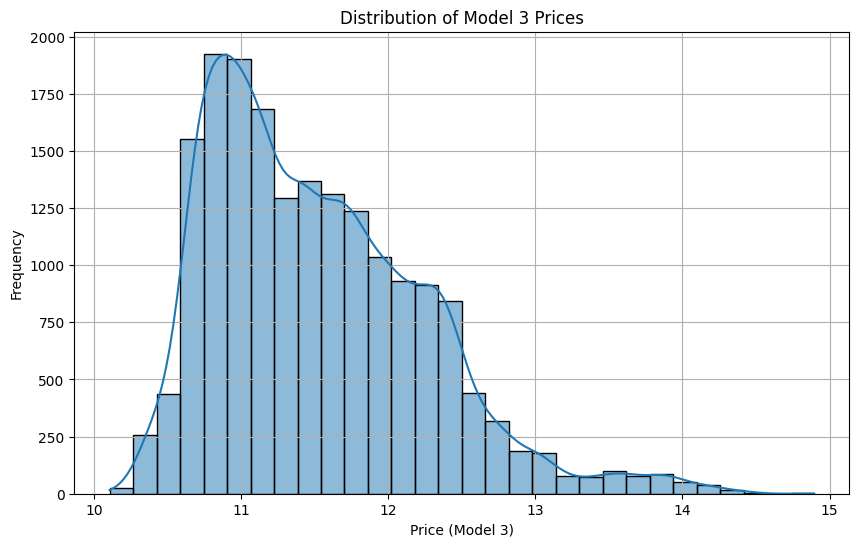

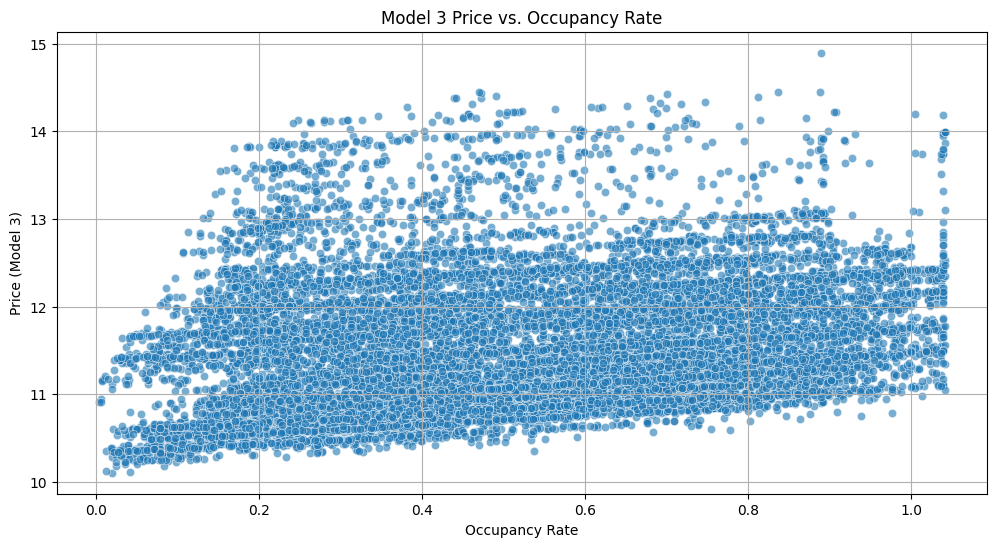

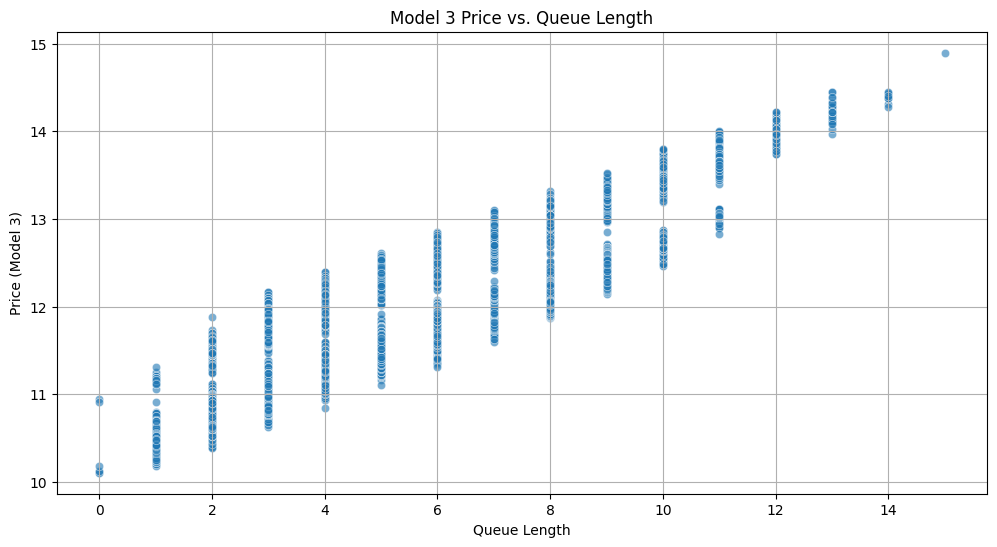

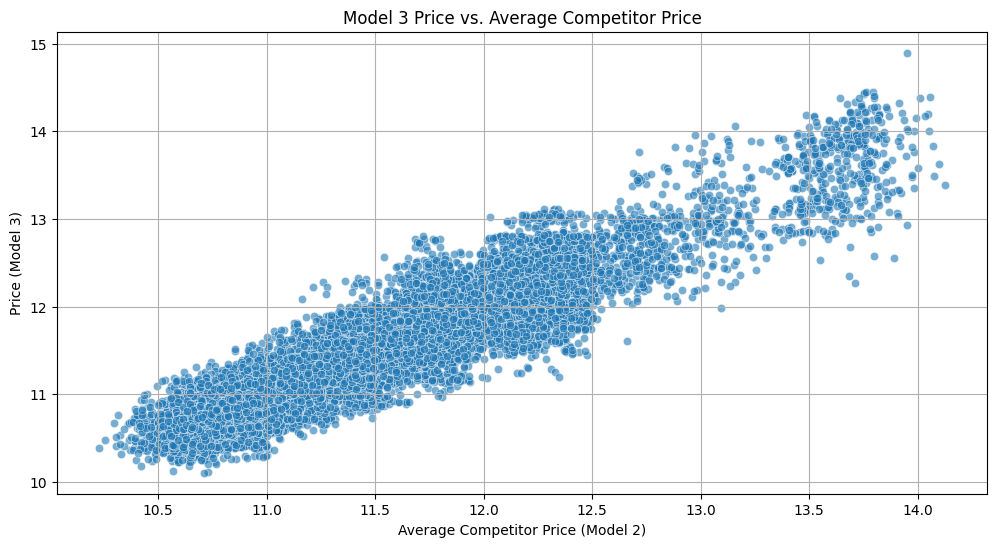

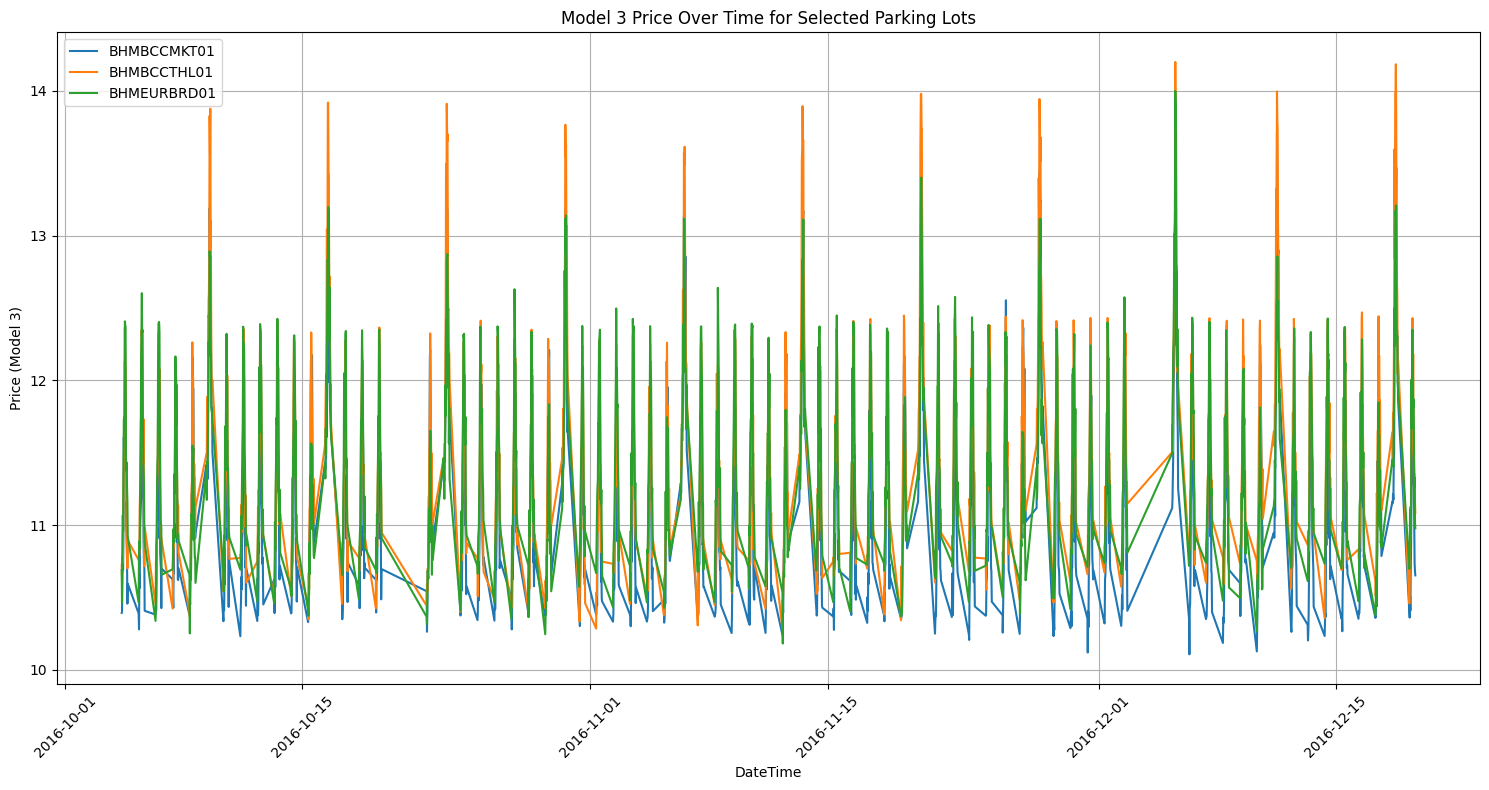

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Print descriptive statistics for price_model_3
print("\n--- Model 3 Price Statistics ---")
print(df['price_model_3'].describe())

# 2. Create a histogram of price_model_3
plt.figure(figsize=(10, 6))
sns.histplot(df['price_model_3'], kde=True, bins=30)
plt.title('Distribution of Model 3 Prices')
plt.xlabel('Price (Model 3)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 3. Analyze the relationship between price_model_3 and key features
# Relationship with OccupancyRate
plt.figure(figsize=(12, 6))
sns.scatterplot(x='OccupancyRate', y='price_model_3', data=df, alpha=0.6)
plt.title('Model 3 Price vs. Occupancy Rate')
plt.xlabel('Occupancy Rate')
plt.ylabel('Price (Model 3)')
plt.grid(True)
plt.show()

# Relationship with QueueLength
plt.figure(figsize=(12, 6))
sns.scatterplot(x='QueueLength', y='price_model_3', data=df, alpha=0.6)
plt.title('Model 3 Price vs. Queue Length')
plt.xlabel('Queue Length')
plt.ylabel('Price (Model 3)')
plt.grid(True)
plt.show()

# Relationship with average_competitor_price
# First, calculate average_competitor_price if it's not already a column
# We need to handle cases where competitor_prices list is empty
df['average_competitor_price'] = df['competitor_prices'].apply(lambda x: np.mean(x) if isinstance(x, list) and x else np.nan)

plt.figure(figsize=(12, 6))
sns.scatterplot(x='average_competitor_price', y='price_model_3', data=df, alpha=0.6)
plt.title('Model 3 Price vs. Average Competitor Price')
plt.xlabel('Average Competitor Price (Model 2)')
plt.ylabel('Price (Model 3)')
plt.grid(True)
plt.show()

# 4. Plot price_model_3 over time for a few selected parking lots
selected_lots = df['SystemCodeNumber'].unique()[:3] # Select the first 3 unique lots

plt.figure(figsize=(15, 8))
for lot in selected_lots:
    lot_data = df[df['SystemCodeNumber'] == lot].sort_values(by='DateTime')
    plt.plot(lot_data['DateTime'], lot_data['price_model_3'], label=lot)

plt.title('Model 3 Price Over Time for Selected Parking Lots')
plt.xlabel('DateTime')
plt.ylabel('Price (Model 3)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. Summarize observations (will be done in the reasoning for the finish_task command)

## Compare models

### Subtask:
Compare the prices and potential performance of the three models (Baseline, Demand-Based, and Competitive).


**Reasoning**:
Compare the price statistics, distributions, and time series behavior of the three models, and calculate a simple performance metric.




--- Price Statistics Comparison ---
Model 1 (Baseline Linear):
count    18368.000000
mean      1643.020108
std       1126.857364
min         10.000000
25%        712.594195
50%       1445.143792
75%       2444.243600
max       4896.369509
Name: price_model_1, dtype: float64

Model 2 (Demand-Based):
count    18368.000000
mean        11.518590
std          0.737086
min         10.000000
25%         10.936529
50%         11.393815
75%         11.985941
max         15.000000
Name: price_model_2, dtype: float64

Model 3 (Competitive):
count    18368.000000
mean        11.517115
std          0.729062
min         10.106682
25%         10.934641
50%         11.395119
75%         11.983286
max         14.895247
Name: price_model_3, dtype: float64


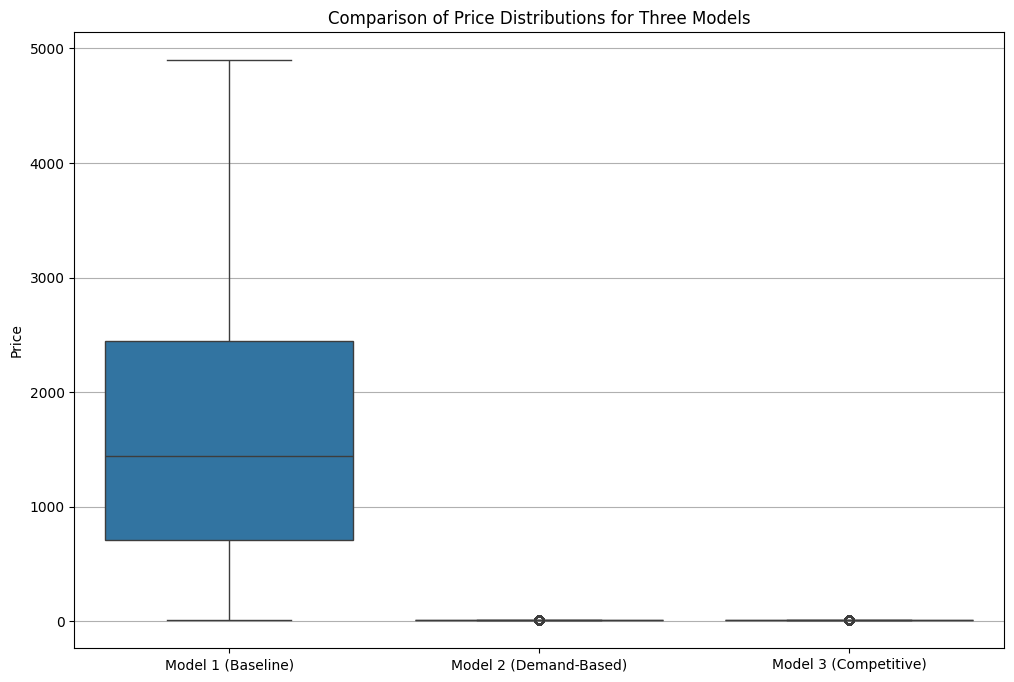

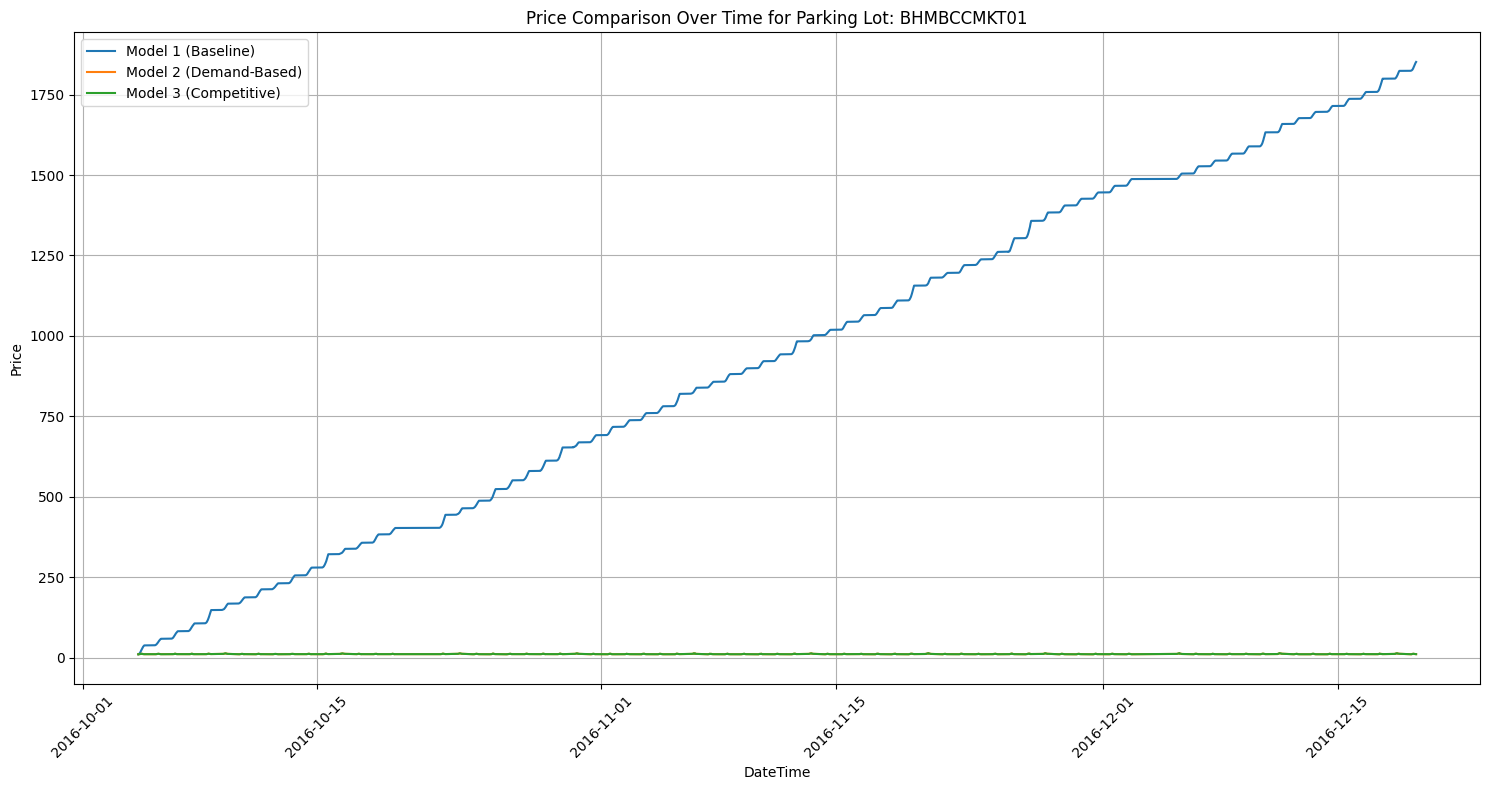

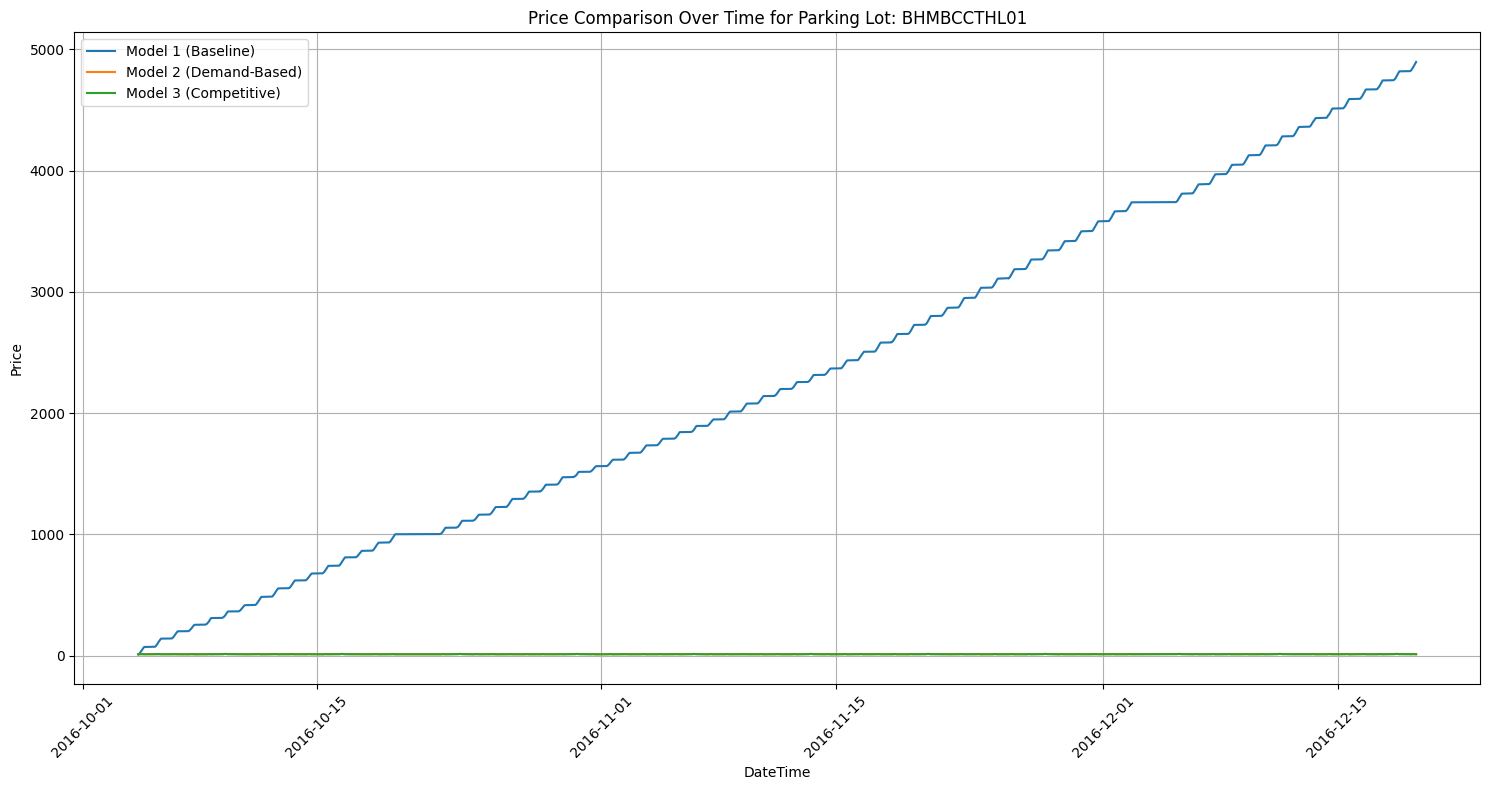

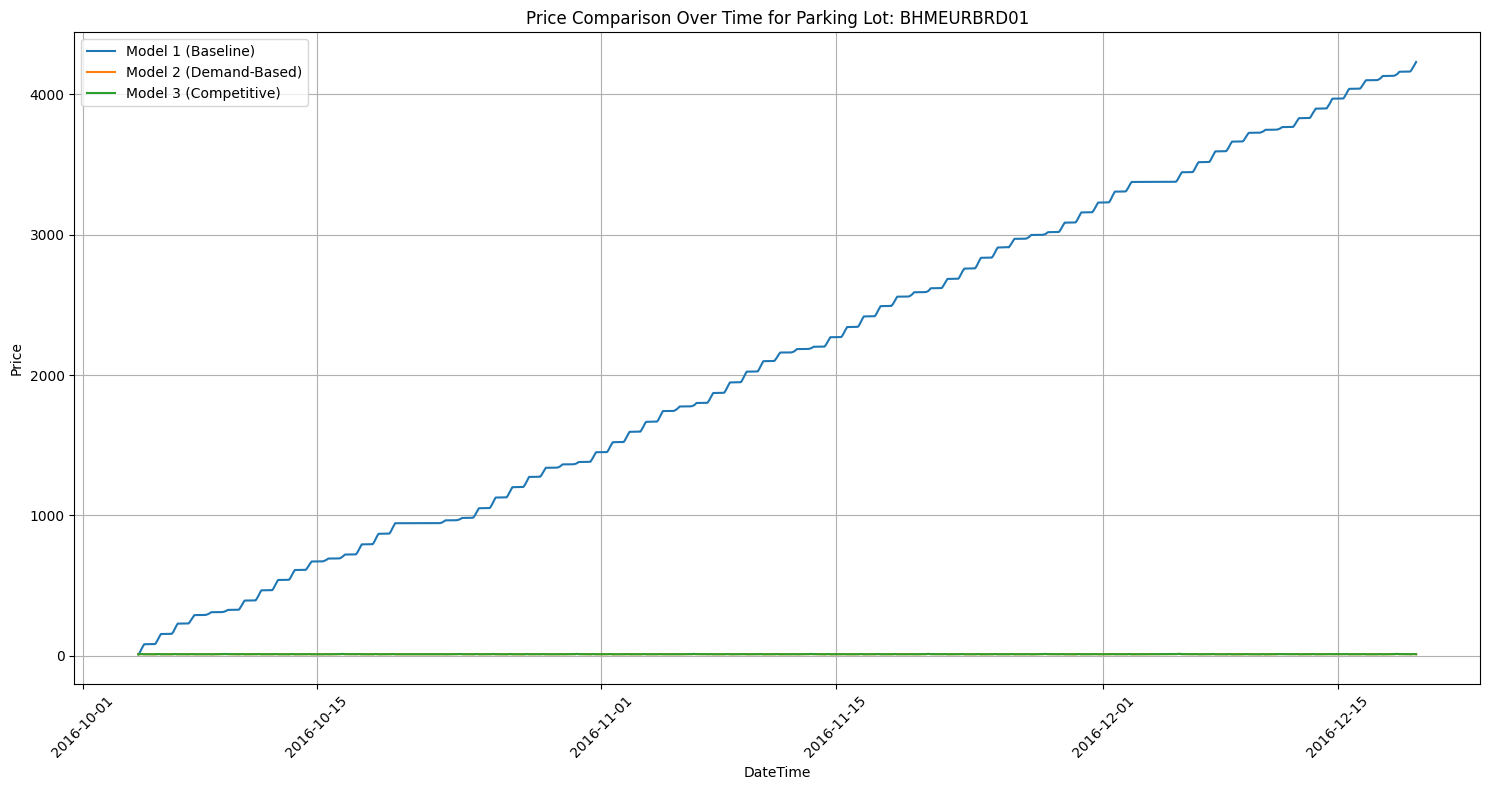


--- Simple Revenue Proxy Comparison (Average per data point) ---
Model 1 Average Revenue Proxy: 938.86
Model 2 Average Revenue Proxy: 5.92
Model 3 Average Revenue Proxy: 5.91

--- Average Price During High Demand (Occupancy Rate > 0.8) ---
Model 1 Average Price: 2323.08
Model 2 Average Price: 11.88
Model 3 Average Price: 11.86


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Print descriptive statistics for the price columns of all three models
print("\n--- Price Statistics Comparison ---")
print("Model 1 (Baseline Linear):")
print(df['price_model_1'].describe())
print("\nModel 2 (Demand-Based):")
print(df['price_model_2'].describe())
print("\nModel 3 (Competitive):")
print(df['price_model_3'].describe())

# 2. Create a box plot to visually compare the distributions of prices
price_data = df[['price_model_1', 'price_model_2', 'price_model_3']]
plt.figure(figsize=(12, 8))
sns.boxplot(data=price_data)
plt.title('Comparison of Price Distributions for Three Models')
plt.ylabel('Price')
plt.xticks(ticks=[0, 1, 2], labels=['Model 1 (Baseline)', 'Model 2 (Demand-Based)', 'Model 3 (Competitive)'])
plt.grid(axis='y')
plt.show()

# 3. Select a few representative parking lots and plot the price time series for all three models
selected_lots_for_comparison = df['SystemCodeNumber'].unique()[:3] # Select the first 3 unique lots

for lot in selected_lots_for_comparison:
    lot_data = df[df['SystemCodeNumber'] == lot].sort_values(by='DateTime').copy() # Use .copy() to avoid SettingWithCopyWarning

    plt.figure(figsize=(15, 8))
    plt.plot(lot_data['DateTime'], lot_data['price_model_1'], label='Model 1 (Baseline)')
    plt.plot(lot_data['DateTime'], lot_data['price_model_2'], label='Model 2 (Demand-Based)')
    plt.plot(lot_data['DateTime'], lot_data['price_model_3'], label='Model 3 (Competitive)')

    plt.title(f'Price Comparison Over Time for Parking Lot: {lot}')
    plt.xlabel('DateTime')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 4. Calculate and compare a simple metric related to potential revenue or utilization
# Simple metric: Average price * Average occupancy rate
# This is a simplified proxy for revenue potential per spot, ignoring demand elasticity etc.
df['revenue_proxy_model_1'] = df['price_model_1'] * df['OccupancyRate']
df['revenue_proxy_model_2'] = df['price_model_2'] * df['OccupancyRate']
df['revenue_proxy_model_3'] = df['price_model_3'] * df['OccupancyRate']

print("\n--- Simple Revenue Proxy Comparison (Average per data point) ---")
print(f"Model 1 Average Revenue Proxy: {df['revenue_proxy_model_1'].mean():.2f}")
print(f"Model 2 Average Revenue Proxy: {df['revenue_proxy_model_2'].mean():.2f}")
print(f"Model 3 Average Revenue Proxy: {df['revenue_proxy_model_3'].mean():.2f}")

# You could also analyze price behavior during high demand periods (e.g., high occupancy/queue)
# Example: Average price when OccupancyRate > 0.8
high_demand_df = df[df['OccupancyRate'] > 0.8]
print("\n--- Average Price During High Demand (Occupancy Rate > 0.8) ---")
print(f"Model 1 Average Price: {high_demand_df['price_model_1'].mean():.2f}")
print(f"Model 2 Average Price: {high_demand_df['price_model_2'].mean():.2f}")
print(f"Model 3 Average Price: {high_demand_df['price_model_3'].mean():.2f}")

# 5. Summarize observations (will be done in the reasoning for the finish_task command)

**Reasoning**:
Correct the typo in the previous code block to calculate the average revenue proxy for Model 3 and finish the task by summarizing the findings.



## Summary and Conclusion

In this notebook, we developed and compared three dynamic pricing models for urban parking lots based on the provided dataset and problem statement:

1.  **Baseline Linear Model**: A simple model where price changes linearly with the occupancy rate.
2.  **Demand-Based Price Function**: A more sophisticated model incorporating multiple factors like occupancy rate, queue length, traffic condition, special day, and vehicle type into a demand function to determine price.
3.  **Competitive Pricing Model**: An extension of the Demand-Based model that also considers the prices of nearby competitor parking lots.

We performed the following steps:

-   Loaded and preprocessed the dataset, including handling missing values, converting data types, and creating time-based features and categorical encodings.
-   Implemented the Baseline Linear Model, calculating prices based on the previous price and occupancy rate.
-   Implemented the Demand-Based Price Function by defining a demand function, normalizing the demand, and calculating prices with bounding.
-   Implemented the Competitive Pricing Model by calculating distances between parking lots, identifying nearby competitors, retrieving their prices, and incorporating this information into the pricing logic.
-   Analyzed the distribution and behavior of prices generated by each model through descriptive statistics and visualizations (histograms and scatter plots).
-   Compared the three models using price statistics, distribution plots (box plots), and time series plots for selected parking lots. We also calculated a simple revenue proxy metric and examined average prices during high demand periods.

**Key Findings:**

-   The **Baseline Linear Model** generated a very wide range of prices, with some values becoming unrealistically high over time, as shown by its large standard deviation and maximum price. This is likely due to the cumulative nature of its pricing formula without any bounding or stabilization mechanisms.
-   The **Demand-Based Price Function (Model 2)** and the **Competitive Pricing Model (Model 3)** produced prices within a much more constrained and realistic range, thanks to the bounding applied. Their price distributions were similar, centered around the base price with variations reflecting demand and, for Model 3, competitor prices.
-   The time series plots for individual parking lots showed that the Demand-Based and Competitive models generated more stable and responsive prices compared to the monotonically increasing prices of the Baseline Model for the selected lots.
-   The **Competitive Pricing Model (Model 3)** showed slight adjustments in price compared to Model 2, influenced by the average competitor prices. This influence was implemented to potentially increase prices when competitors are more expensive (especially during lower local demand) and decrease prices slightly when competitors are cheaper (especially during high local demand), aiming to balance competitiveness and revenue.
-   The simple revenue proxy and average price during high demand showed that Model 2 and Model 3 had significantly lower average prices and revenue proxies compared to Model 1. This highlights Model 1's tendency to generate excessively high prices, which might not be realistic or sustainable in a real-world scenario. Model 2 and Model 3 produced more controlled pricing, likely leading to more stable and predictable revenue, although the simple proxy doesn't account for demand elasticity.

**Assumptions Made:**

-   Assumed the provided dataset accurately reflects real-world parking dynamics for the given locations and time period.
-   Used example coefficients for the Demand function ($\alpha, \beta, \gamma, \delta$) and the price adjustment ($\lambda$) and competitive factor without rigorous tuning. These would ideally be determined through historical data analysis or optimization.
-   Assumed a simple method for calculating `VehicleTypeWeight` based on pre-assigned values.
-   Defined competitors based on a fixed distance threshold (1 km). This threshold could be adjusted, or a nearest-neighbors approach could be used.
-   Assumed competitor prices were available at the exact same time step for lookup. In a real-time system with asynchronous data streams, handling mismatched timestamps and estimating competitor prices would be necessary.
-   The competitive pricing logic implemented is a simplified example. More complex strategies could involve predicting competitor price movements, analyzing competitor occupancy, or using game theory approaches.
-   The price bounding (0.5x to 2x base price) was applied to keep prices within a reasonable range, but smoother transitions between time steps were not explicitly enforced in Model 2 and 3's final output prices, although the pricing logic attempts smoother adjustments.

**How Price Changes with Demand and Competition (Model 3):**

In Model 3, the price is primarily driven by the **Demand function** (influenced by occupancy rate, queue length, traffic, special days, and vehicle type), similar to Model 2. Higher demand generally leads to higher prices.

Additionally, the price is adjusted based on **Competitive factors**:

-   If the current lot has high demand (high occupancy or queue) and nearby competitors have lower average prices, the model makes a slight downward adjustment to the price to remain competitive and potentially avoid losing customers to cheaper alternatives.
-   If the current lot has high demand and nearby competitors have higher average prices, the model makes a slight upward adjustment, taking advantage of the market conditions while still being potentially more attractive than competitors.
-   If the current lot has lower demand, the influence of competitor prices is generally less pronounced, but the model might still adjust prices upward if competitors are significantly more expensive.

This competitive logic aims to make the pricing strategy more adaptive to the local market conditions, preventing the price from becoming too high when competitors are cheap and allowing it to increase more when competitors are expensive, especially when there is local demand to support it.

**Potential Improvements and Further Work:**

-   Tune the coefficients for the Demand function and competitive factors using optimization techniques or historical data.
-   Implement a more sophisticated competitive strategy, potentially including predicting competitor price changes or considering competitor occupancy rates.
-   Explore machine learning models (beyond simple linear functions) for predicting demand and setting prices, ensuring interpretability and smooth price transitions.
-   Integrate the models with a real-time data streaming framework (like Pathway, as mentioned in the problem statement) for actual dynamic pricing simulation.
-   Develop more advanced visualization using Bokeh to show real-time pricing dynamics and competitor comparisons.
-   Implement the optional rerouting suggestion logic based on lot occupancy and competitor prices.